# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Preliminaries: Imports & Data Load

In [1]:
# imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import cv2
import random
import pickle
import time
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
# load train, valid & test data

# (a) filenames
training_file   = "train.p"
validation_file = "valid.p"
testing_file    = "test.p"

# (b) load
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# (c) extract
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test   = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
def get_training_size(X_train):
    # Number of training examples
    _n_train = len(X_train)
    print("Number of training examples   =", _n_train)
    return(_n_train)

n_train = get_training_size(X_train)

# Number of validation examples
n_validation = len(X_valid)
print("Number of validation examples =", n_validation)

# Number of testing examples.
n_test = len(X_test)
print("Number of testing examples    =", n_test)

# the shape of an image
image_shape = X_train[0].shape
print("Image data shape              =", image_shape)

# unique labels
n_classes = len(np.unique(y_train))
print("Number of classes             =", n_classes)

Number of training examples   = 34799
Number of validation examples = 4410
Number of testing examples    = 12630
Image data shape              = (32, 32, 3)
Number of classes             = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

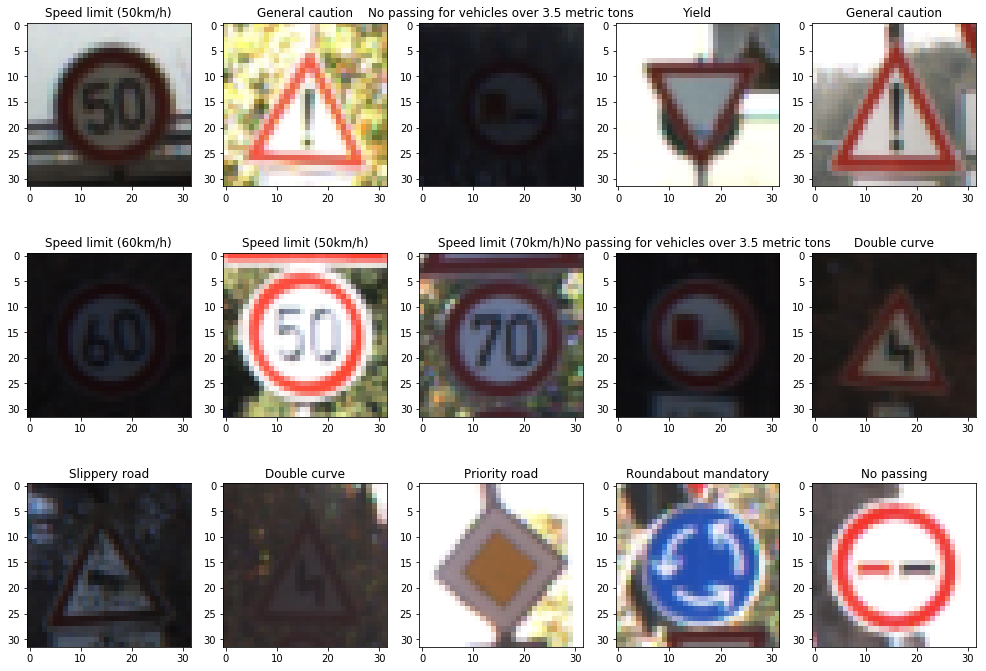

In [4]:
# (I) Randomly choose 15 plots and describe what they mean

# (a) read the relationship between label numbers and sign names
#     froma file and arrange it in a dictionary
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    mydict = {rows[0]:rows[1] for rows in reader}

# (b) plot images[0] x images[1] images with their meaning
plt.figure(figsize=(17,12))
images = (3, 5)
for j in range(images[0]):
    for i in range(images[1]):
        index = random.randint(0, len(X_train))
        image = X_train[index].squeeze()
        k = images[1]*j + i +1
        plt.subplot(images[0],images[1],k)
        plt.imshow(image)
        _str = mydict[str(y_train[index])]
        plt.title('%s' % _str)

Train
mean samples per class = 809
minimum sample is 180 from class 0
maximum sample is 2010 from class 2
mean to min ratio = 4.50

training samples from label "Speed limit (20km/h)                        " = 180
training samples from label "Speed limit (30km/h)                        " = 1980
training samples from label "Speed limit (50km/h)                        " = 2010
training samples from label "Speed limit (60km/h)                        " = 1260
training samples from label "Speed limit (70km/h)                        " = 1770
training samples from label "Speed limit (80km/h)                        " = 1650
training samples from label "End of speed limit (80km/h)                 " = 360
training samples from label "Speed limit (100km/h)                       " = 1290
training samples from label "Speed limit (120km/h)                       " = 1260
training samples from label "No passing                                  " = 1320
training samples from label "No passing for vehicl

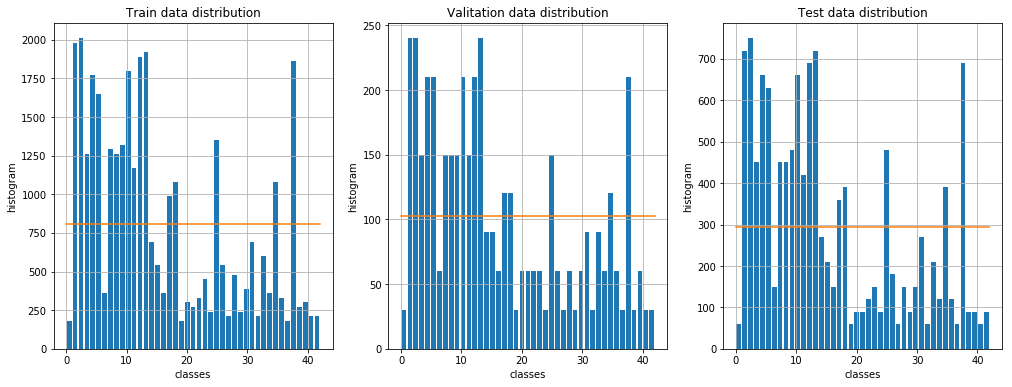

In [6]:
# (II) Check statistics of classes
def get_hist(_in,_text):
    _mean = len(_in)/n_classes
    _temp,_,_ = plt.hist(_in, n_classes, rwidth=0.8)
    # train_sizes shows the frequency of the occurence of each class 
    train_sizes = np.array(_temp,dtype=int)
    _min  = train_sizes.min()
    _min_l= train_sizes.argmin()
    _max  = train_sizes.max()
    _max_l= train_sizes.argmax()
    print(_text)
    print('mean samples per class = {:.0f}'.format(_mean))
    print('minimum sample is {:.0f} from class {:.0f}'.format(_min,_min_l))
    print('maximum sample is {:.0f} from class {:.0f}'.format(_max,_max_l))
    print('mean to min ratio = {:.2f}'.format(_mean/_min))
    print()
    plt.plot(np.arange(0,n_classes),_mean*np.ones((n_classes)))
    plt.xlabel('classes')
    plt.ylabel('histogram')
    plt.title('%s data distribution' % _text)
    plt.grid()
    return(train_sizes)

plt.figure(figsize=(17,6))   
plt.subplot(1,3,1)
train_sizes = get_hist(y_train, 'Train')
for i in range(n_classes):
    _str = mydict[str(i)]
    print('training samples from label "{:44}" = {}'.format(_str,train_sizes[i]))
plt.subplot(1,3,2)
get_hist(y_valid, 'Valitation')
plt.subplot(1,3,3)
_ = get_hist(y_test, 'Test')

In [7]:
# random number generator
def get_rv(max_range):
    return(np.random.uniform(-max_range,max_range))

# Translation/shear + rotation + brightness
def transform_image(_img, max_shift, max_shear, max_angle, min_sat):  
    
    # (A) Translation + shear
    shift_x = get_rv(max_shift)
    shift_y = get_rv(max_shift)
    shear_x = get_rv(max_shear)
    shear_y = get_rv(max_shear)
    TS      = np.float32([[1,shear_x,shift_x],[shear_y,1,shift_y]])
    
    # (B) Rotation at center without scaling
    random_angle = get_rv(max_angle)
    rows,cols,_ = _img.shape
    center       = (cols/2,rows/2)   
    R    = cv2.getRotationMatrix2D(center,random_angle,1)

    _img_1 = cv2.warpAffine(_img,R,(cols,rows))
    _img_2 = cv2.warpAffine(_img_1,TS,(cols,rows))

    # (C) saturation
    if(MIN_SAT == 1):
        return(_img_2)
    else:
        _img_3 = cv2.cvtColor(_img_2,cv2.COLOR_RGB2HSV)  #RGB -> HSV
        _img_3[:,:,2] = np.random.uniform(min_sat,1) * _img_3[:,:,2]
        return(cv2.cvtColor(_img_3,cv2.COLOR_HSV2RGB))

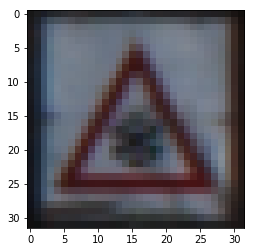

In [8]:
#pick an image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.imshow(image)

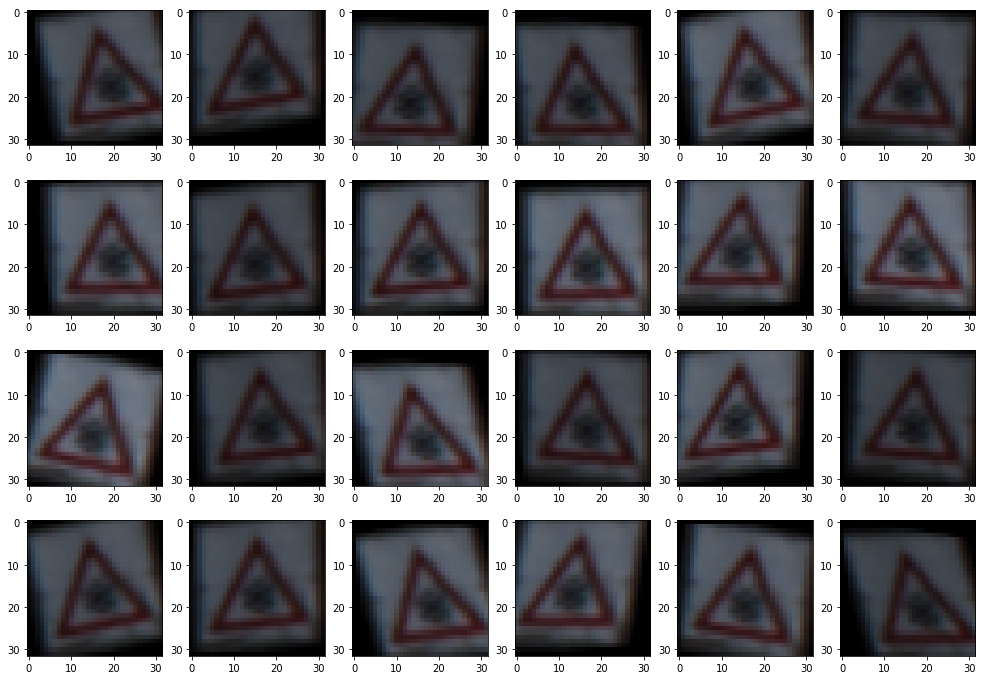

In [10]:
# explore
MAX_SHIFT    = 2
MAX_SHEAR    = 0.15 
MAX_ANGLE    = 10
MIN_SAT      = 0.5

plt.figure(figsize=(17,12))
images = (4, 6)

for j in range(images[0]):
    for i in range(images[1]):      
        k = images[1]*j + i +1
        plt.subplot(images[0],images[1],k)
        _img = transform_image(image,MAX_SHIFT,MAX_SHEAR,MAX_ANGLE,MIN_SAT)
        plt.imshow(_img)

In [11]:
# determines additions to be made
AUGMENT_FLAG   = True
MIN_CLASS_SIZE = 2000

additions = MIN_CLASS_SIZE - train_sizes
additions = additions.astype(int)
additions = additions.clip(min=0) 

# quotients and remainders
cycles = additions // train_sizes
rem = additions % train_sizes

# sort the labels (sorted_index is the list of labels where the sorting is on the classes)
sorted_index = np.argsort(y_train)
# identify class switch positions
class_boundary = train_sizes.cumsum()
class_boundary = class_boundary.astype(int)
# split classes
class_index = np.split(sorted_index,class_boundary)


if (AUGMENT_FLAG == True):
    for i in range(n_classes):
        if(train_sizes[i]< MIN_CLASS_SIZE):
            (print('class number {:2}: orig. size={}, add={}, cycles={}, rem={}'
                  .format(i,train_sizes[i],additions[i],cycles[i],rem[i])))
            # go through training data as many cycles as needed
            _class = class_index[i]
            ii     = np.expand_dims(i, 0)
            for j in range(cycles[i]):
                for k in range(train_sizes[i]):
                    _img_orig = X_train[_class[k]] 
                    X_new = transform_image(_img_orig,MAX_SHIFT,MAX_SHEAR,MAX_ANGLE,MIN_SAT)
                    X_new = np.expand_dims(X_new, 0)
                    X_train = np.concatenate((X_train, X_new))
                    y_train = np.concatenate((y_train, ii))
            for k in range(rem[i]):
                _img_orig = X_train[_class[k]] 
                X_new = transform_image(_img_orig,MAX_SHIFT,MAX_SHEAR,MAX_ANGLE,MIN_SAT)
                X_new = np.expand_dims(X_new, 0)
                X_train = np.concatenate((X_train, X_new))
                y_train = np.concatenate((y_train, ii))

class number  0: orig. size=180, add=1820, cycles=10, rem=20
class number  1: orig. size=1980, add=20, cycles=0, rem=20
class number  3: orig. size=1260, add=740, cycles=0, rem=740
class number  4: orig. size=1770, add=230, cycles=0, rem=230
class number  5: orig. size=1650, add=350, cycles=0, rem=350
class number  6: orig. size=360, add=1640, cycles=4, rem=200
class number  7: orig. size=1290, add=710, cycles=0, rem=710
class number  8: orig. size=1260, add=740, cycles=0, rem=740
class number  9: orig. size=1320, add=680, cycles=0, rem=680
class number 10: orig. size=1800, add=200, cycles=0, rem=200
class number 11: orig. size=1170, add=830, cycles=0, rem=830
class number 12: orig. size=1890, add=110, cycles=0, rem=110
class number 13: orig. size=1920, add=80, cycles=0, rem=80
class number 14: orig. size=690, add=1310, cycles=1, rem=620
class number 15: orig. size=540, add=1460, cycles=2, rem=380
class number 16: orig. size=360, add=1640, cycles=4, rem=200
class number 17: orig. size=

Number of training examples   = 86010
augmented training
mean samples per class = 2000
minimum sample is 2000 from class 0
maximum sample is 2010 from class 2
mean to min ratio = 1.00



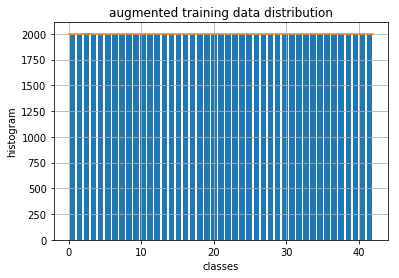

In [12]:
# histogram after augmentation

if (AUGMENT_FLAG == True):
    n_train = get_training_size(X_train)
    _ = get_hist(y_train, 'augmented training')

    with open('aug_train.p', mode='wb') as f:
        pickle.dump([X_train,y_train],f)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [13]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def grayscale(X,_flag,_name):
    if (_flag == True):
        xs = X.shape
        Y = np.empty([xs[0], xs[1], xs[2]])
        for i in range(len(X)):
            Y[i] = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
    else:
        Y=X
    print('{} shape = {}'.format(_name,Y.shape))
    return(Y)

def norm_images(X,_flag,_name):
    if (_flag == True):
        X_norm  = (X - 128.0)/ 128.0
        #X_norm  = X-128.0
    else:
        X_norm = X
    print('{} min = {}, max = {}'.format(_name,np.min(X_norm), np.max(X_norm)))
    return(X_norm)

### Miscellaneous

In [14]:
# for dropout
keep_prob = tf.placeholder(tf.float32)

### Model Architecture

In [15]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten
 
def activation(_in,_name,_mode):
    if(_mode == 0):
        return(tf.nn.tanh(_in,_name))
    elif (_mode == 1):
        return(tf.nn.relu(_in,_name))
    elif (_mode == 2):
        return(tf.nn.elu(_in, _name))
    elif (_mode == 3):
        return(tf.nn.sigmoid(_in, _name))
    elif (_mode == 4):
        return(tf.nn.softplus(_in, _name))


def ArNet(x,sigma,grayscale_flag): 
    # architectural parameters
    FEATURES          = (64, 128)  #features (or depth) for conv layers 1 and 2 respectively
    CONV_KERNEL      = (5, 5)     #for conv layers 1 and 2 respectively
    POOL_STRIDES      = (2, 2)     #pool strides for layers 1 and 2 respectively
    FC_DIM            = 128        #units in fully connected layer
    ACTIVATION_MODE   = 0          #0=tanh, 1=relu, 2=elu, 3=sigmoid, 4=softmax
    
    if (grayscale_flag == True):
        colors = 1
    else:    
        colors = image_shape[2]          #image depth
    
    # Layer 1: 32x32xcolors --> 28x28xFEATURES[0]
    conv1_s = (CONV_KERNEL[0], CONV_KERNEL[0], colors, FEATURES[0])
    conv1_par = CONV_KERNEL[0] * CONV_KERNEL[0] * colors * (FEATURES[0]+1)
    conv1_W = tf.Variable(tf.truncated_normal(shape=conv1_s, mean = 0, stddev = sigma),name="conv1_W")
    conv1_b = tf.Variable(tf.zeros(FEATURES[0]),name="conv1_b")
    if (grayscale_flag == True):
        y = tf.expand_dims(x, 3)
        conv1   = tf.nn.conv2d(y, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    else:
         conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1   = activation(conv1,'conv1_a',ACTIVATION_MODE)
    l1_conv_dim = image_shape[0] - CONV_KERNEL[0]+1
    
    # Pooling. Input = 28x28xconv1_f --> 14x14xFEATURES[0].
    l1_pool_size = (1, POOL_STRIDES[0], POOL_STRIDES[0], 1)
    conv1 = tf.nn.max_pool(conv1, ksize=l1_pool_size, strides=l1_pool_size, padding='VALID',name='conv1_out')
    l1_pool_dim = int(l1_conv_dim/l1_pool_size[1])
    (print('layer-1: ({:3} x {:3} x {:3}) --> ({:3} x {:3} x {:3}) --> ({:3} x {:3} x {:3})'
          .format(image_shape[0], image_shape[1], colors, l1_conv_dim, l1_conv_dim, FEATURES[0],
                  l1_pool_dim, l1_pool_dim, FEATURES[0])))
    
    # Layer 2: Convolutional. 14x14xconv1_f --> 10x10xconv2_f
    conv2_s = (CONV_KERNEL[1], CONV_KERNEL[1], FEATURES[0], FEATURES[1])
    conv2_par = CONV_KERNEL[1] * CONV_KERNEL[1] * FEATURES[0] * (FEATURES[1]+1)
    conv2_W = tf.Variable(tf.truncated_normal(shape=conv2_s, mean = 0, stddev = sigma),name="conv2_W")
    conv2_b = tf.Variable(tf.zeros(conv2_s[3]),name="conv2_b")
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2   = activation(conv2,'conv2_a',ACTIVATION_MODE)
    #conv2   = tf.nn.dropout(conv2,keep_prob)
    l2_conv_dim = l1_pool_dim - CONV_KERNEL[1]+1
  
    # Pooling & flatten: 10x10xconv2_f --> 5x5xconv2_f
    l2_pool_size = (1, POOL_STRIDES[1], POOL_STRIDES[1], 1)
    conv2     = tf.nn.max_pool(conv2, ksize=l2_pool_size, strides=l2_pool_size, padding='VALID',name='conv2_out')
    l2_pool_dim = int(l2_conv_dim/l2_pool_size[1])
    fc_in_dim = l2_pool_dim * l2_pool_dim * conv2_s[3]
    fc_in     = flatten(conv2)
    (print('layer-2: ({:3} x {:3} x {:3}) --> ({:3} x {:3} x {:3}) --> ({:3} x {:3} x {:3})'
          .format(l1_pool_dim, l1_pool_dim, FEATURES[0], l2_conv_dim, l2_conv_dim, FEATURES[1],
                  l2_pool_dim, l2_pool_dim, FEATURES[1])))
    
    # Layer 3: Fully Connected. 25*conv2_f --> fc1_f
    fc1_par = (fc_in_dim + 1) * FC_DIM
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc_in_dim, FC_DIM), mean = 0, stddev = sigma),name="fc1_W")
    fc1_b = tf.Variable(tf.zeros(FC_DIM),name="fc1_b")
    fc1   = tf.matmul(fc_in, fc1_W) + fc1_b
    fc1   = activation(fc1,'fc1_a',ACTIVATION_MODE)
    fc1   = tf.nn.dropout(fc1,keep_prob)
    print('layer-3: {:4} --> {:4}'.format(fc_in_dim, FC_DIM))

    # Layer 4: Fully Connected. fc1_f --> n_classes
    fc2_par = (FC_DIM + 1) * n_classes
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(FC_DIM, n_classes), mean = 0, stddev = sigma),name="fc2_W")
    fc2_b  = tf.Variable(tf.zeros(n_classes),name="fc2_b")
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    print('layer-4: {:4} --> {:4}'.format(FC_DIM,n_classes))
    print()
    print('layer-1 trainable parameters = {:6}'.format(conv1_par))
    print('layer-2 trainable parameters = {:6}'.format(conv2_par))
    print('layer-3 trainable parameters = {:6}'.format(fc1_par))
    print('layer-4 trainable parameters = {:6}'.format(fc2_par))
    print('total   trainable parameters = {:6}'.format(conv1_par+conv2_par+fc1_par+fc2_par))
    
    return logits

### Hyper-parameters

In [16]:
# hyper parameters
MAX_EPOCHS    = 200             # training iterations
ACCURACY_GOAL = 0.99
BATCH_SIZE    = 128             # mini-batch size
L_RATE        = 0.00008         # learning rate
W_STD         = 0.04            # std for weight initialization
USE_GRAYSCALE = True            # if True then convert to Grayscale
USE_NORM      = False            # if true then normalize mean/variation
KEEP_PROB     = 0.3
SAVER_FN      = 'arnet7'

### Preprocess data

In [17]:
# grayscale images if set to do so
X_train_color = grayscale(X_train,USE_GRAYSCALE,'training  :')
X_valid_color = grayscale(X_valid,USE_GRAYSCALE,'validation:')
X_test_color  = grayscale(X_test,USE_GRAYSCALE,'test      :')

# normalize images if set to do so
X_train_norm = norm_images(X_train_color,USE_NORM,'training  :')
X_valid_norm = norm_images(X_valid_color,USE_NORM,'validation:')
X_test_norm  = norm_images(X_test_color,USE_NORM,'testing   :')

training  : shape = (86010, 32, 32)
validation: shape = (4410, 32, 32)
test      : shape = (12630, 32, 32)
training  : min = 0.0, max = 255.0
validation: min = 5.0, max = 255.0
testing   : min = 4.0, max = 255.0


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [18]:
# Append Cost, optimization gradient & predictor to graph
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

# placeholder for mini-batches
if (USE_GRAYSCALE == True):
    x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1]),name='x') 
else:
    x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1],image_shape[2]),name='x') 
y = tf.placeholder(tf.int32, (None),name='y')
# one-hot format for y
one_hot_y = tf.one_hot(y, n_classes)

logits             = ArNet(x,W_STD,USE_GRAYSCALE)
cross_entropy      = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation     = tf.reduce_mean(cross_entropy)
optimizer          = tf.train.AdamOptimizer(learning_rate = L_RATE)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

layer-1: ( 32 x  32 x   1) --> ( 28 x  28 x  64) --> ( 14 x  14 x  64)
layer-2: ( 14 x  14 x  64) --> ( 10 x  10 x 128) --> (  5 x   5 x 128)
layer-3: 3200 -->  128
layer-4:  128 -->   43

layer-1 trainable parameters =   1625
layer-2 trainable parameters = 206400
layer-3 trainable parameters = 409728
layer-4 trainable parameters =   5547
total   trainable parameters = 623300


In [19]:
def evaluate_accuracy(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
# train & validate
validation_accuracy = np.empty(MAX_EPOCHS)
training_loss       = np.zeros(MAX_EPOCHS)
start_time = time.time()

# Constructor for Saver class
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)   

    print("Train & validate: ")
    #for i in range(MAX_EPOCHS):
    _acc = 0.0
    i = 0
    while ((_acc < ACCURACY_GOAL) & (i<MAX_EPOCHS)):
        X_train_s, y_train_s = shuffle(X_train_norm, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_s[offset:end], y_train_s[offset:end]
            _loss,_ = (sess.run([loss_operation, training_operation], 
                                    feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB}))
            training_loss[i] += _loss  
        validation_accuracy[i] = evaluate_accuracy(X_valid_norm, y_valid)
        print("{}:({:.3f},{:.1e}), ".format(i+1,validation_accuracy[i],training_loss[i]),end='')
        _acc = validation_accuracy[i] 
        i += 1
        
    exec_time = time.time() - start_time
    print()
    print("Simulation took {:.0f} seconds or {:.2f} minutes".format(exec_time,exec_time/60.0))
    saver.save(sess, SAVER_FN)
    print("Model saved")

Train & validate: 
1:(0.727,1.9e+03), 2:(0.850,1.1e+03), 3:(0.905,7.9e+02), 4:(0.928,5.8e+02), 5:(0.950,4.5e+02), 6:(0.958,3.5e+02), 7:(0.963,2.9e+02), 8:(0.971,2.4e+02), 9:(0.970,2.0e+02), 10:(0.972,1.8e+02), 11:(0.975,1.6e+02), 12:(0.977,1.3e+02), 13:(0.977,1.2e+02), 14:(0.978,1.1e+02), 15:(0.979,9.7e+01), 16:(0.979,8.8e+01), 17:(0.980,8.1e+01), 18:(0.981,7.4e+01), 19:(0.980,6.9e+01), 20:(0.977,6.3e+01), 21:(0.978,5.6e+01), 22:(0.977,5.5e+01), 23:(0.980,5.1e+01), 24:(0.979,4.7e+01), 25:(0.980,4.5e+01), 26:(0.981,4.1e+01), 27:(0.978,3.9e+01), 28:(0.982,3.7e+01), 29:(0.980,3.5e+01), 30:(0.980,3.2e+01), 31:(0.982,3.2e+01), 32:(0.980,3.1e+01), 33:(0.983,2.9e+01), 34:(0.983,2.8e+01), 35:(0.977,2.6e+01), 36:(0.982,2.5e+01), 37:(0.980,2.4e+01), 38:(0.978,2.4e+01), 39:(0.983,2.1e+01), 40:(0.980,2.1e+01), 41:(0.979,2.0e+01), 42:(0.985,2.1e+01), 43:(0.983,1.9e+01), 44:(0.978,1.9e+01), 45:(0.980,1.8e+01), 46:(0.982,1.7e+01), 47:(0.983,1.7e+01), 48:(0.985,1.6e+01), 49:(0.982,1.6e+01), 50:(0.980,

### Plot

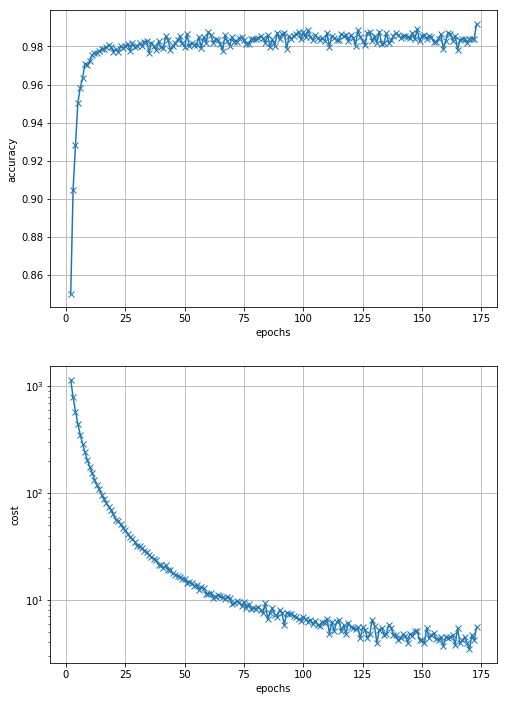

In [21]:
epochs = np.arange(1,MAX_EPOCHS+1)
plt.figure(figsize=(8,12))  

plt.subplot(2,1,1)
plt.plot(epochs[1:i],validation_accuracy[1:i],'-x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.subplot(2,1,2)
plt.semilogy(epochs[1:i],training_loss[1:i],'-x')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.grid()

In [22]:
# final test
#TEST_FN = 'arnet2'
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, TEST_FN)
    test_accuracy = evaluate_accuracy(X_test_norm, y_test)
print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.973


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

image: w1.jpg
input   shape of w1.jpg is (180, 240, 3)
cropped shape of w1.jpg is (155, 200, 3)
shape is (1, 32, 32) of dtype uint8
output shape is (1, 32, 32) of dtype float32

image: w2.jpg
input   shape of w2.jpg is (183, 275, 3)
cropped shape of w2.jpg is (155, 190, 3)
shape is (1, 32, 32) of dtype uint8
output shape is (1, 32, 32) of dtype float32

image: w3.jpg
input   shape of w3.jpg is (194, 259, 3)
cropped shape of w3.jpg is (90, 100, 3)
shape is (1, 32, 32) of dtype uint8
output shape is (1, 32, 32) of dtype float32

image: w4.jpg
input   shape of w4.jpg is (188, 269, 3)
cropped shape of w4.jpg is (170, 269, 3)
shape is (1, 32, 32) of dtype uint8
output shape is (1, 32, 32) of dtype float32

image: w5.jpg
input   shape of w5.jpg is (280, 180, 3)
cropped shape of w5.jpg is (85, 90, 3)
shape is (1, 32, 32) of dtype uint8
output shape is (1, 32, 32) of dtype float32



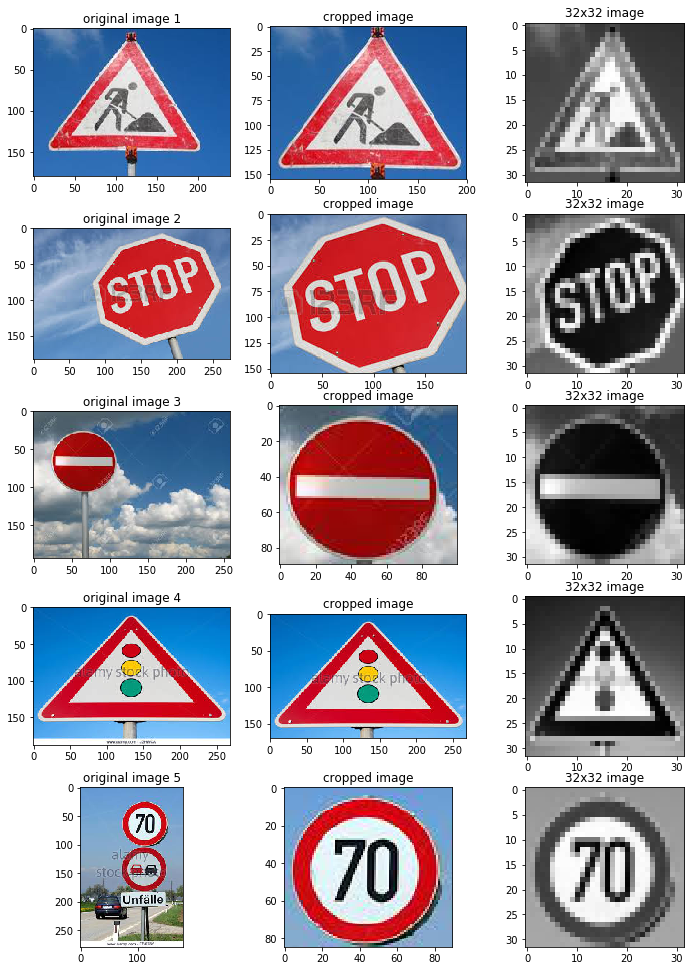

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def prepare_image(image_name,crop,number,verbose):
    # (a) load
    _img_in = cv2.imread(image_name)
    if (verbose == True):
        print('image: {}'.format(image_name))
        print('input   shape of {} is {}'.format(image_name,_img_in.shape))
    k = 3*(number-1)+1
    plt.subplot(5,3,k)
    _img_rgb = cv2.cvtColor(_img_in, cv2.COLOR_BGR2RGB)
    plt.imshow(_img_rgb)
    plt.title('original image %d' % number)
    
    # (b) crop
    _img_crop = _img_rgb[crop[2]:crop[3], crop[0]:crop[1],:]
    if (verbose == True):
        print('cropped shape of {} is {}'.format(image_name,_img_crop.shape))
    plt.subplot(5,3,k+1)
    plt.imshow(_img_crop) 
    plt.title('cropped image')
    
    # (c) resize
    _img_32 = cv2.resize(_img_crop,(32,32),interpolation=cv2.INTER_AREA)
    
    # (d) grey
    _img_gry = cv2.cvtColor(_img_32, cv2.COLOR_RGB2GRAY)
    plt.subplot(5,3,k+2)
    plt.imshow(_img_gry,cmap='gray') 
    plt.title('32x32 image')
    
    # (e) add dimension for batch
    _img_3d = np.expand_dims(_img_gry, 0)
    if (verbose == True):
        print('shape is {} of dtype {}'.format(_img_3d.shape, _img_3d.dtype))
    
    # (f) make it floating point
    _img_out = _img_3d.astype(np.float32)
    if (verbose == True):
        print('output shape is {} of dtype {}'.format(_img_out.shape, _img_out.dtype))
        print()
    return(_img_out)

# view images
plt.figure(figsize=(12,17))
x_explore = np.empty([5,32,32])
y_explore = np.array([25, 14, 17, 26, 4])
crop_coord = ((10,210,5,160),(70,260,5,160),(20,120,20,110),(0,270,0,170),(70,160,20,105))
verbose = True
for i in range(5):
    image_name = 'w%d.jpg' % (i+1) 
    x_explore[i] = prepare_image(image_name,crop_coord[i],i+1,verbose)
              
#y_explore = np.expand_dims(y_explore, 0)

### Predict the sign type for each image and analyze performance output of the top 5 softmax probabilities For each image found on the web

In [24]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    _logits, _one_hot_y, accuracy, p_c = (sess.run([logits, one_hot_y, correct_prediction, accuracy_operation], 
                                              feed_dict={x: x_explore, y: y_explore, keep_prob: 1.0}))
    _softmax        = tf.nn.softmax(_logits)
    _values, _index = tf.nn.top_k(_softmax, k=5)
    _softmax_v = _values.eval()
    _softmax_i = _index.eval()
    for i in range(5):
        print('Image {}:'.format(i+1))
        for j in range(5):
            _str = mydict[str(_softmax_i[i,j])]
            print('prob({:40}) = {:.5f}'.format(_str,_softmax_v[i,j]))
        print("Image Accuracy = {}".format(accuracy[i]))
        print()
    print('Accuracy = {:.2f} %'.format(100*p_c))

Image 1:
prob(Road work                               ) = 0.99999
prob(Slippery road                           ) = 0.00000
prob(Bumpy road                              ) = 0.00000
prob(Speed limit (60km/h)                    ) = 0.00000
prob(Beware of ice/snow                      ) = 0.00000
Image Accuracy = True

Image 2:
prob(Stop                                    ) = 1.00000
prob(Turn right ahead                        ) = 0.00000
prob(Speed limit (60km/h)                    ) = 0.00000
prob(Speed limit (50km/h)                    ) = 0.00000
prob(Keep right                              ) = 0.00000
Image Accuracy = True

Image 3:
prob(No entry                                ) = 1.00000
prob(No passing                              ) = 0.00000
prob(End of no passing                       ) = 0.00000
prob(Vehicles over 3.5 metric tons prohibited) = 0.00000
prob(Stop                                    ) = 0.00000
Image Accuracy = True

Image 4:
prob(Traffic signals                    

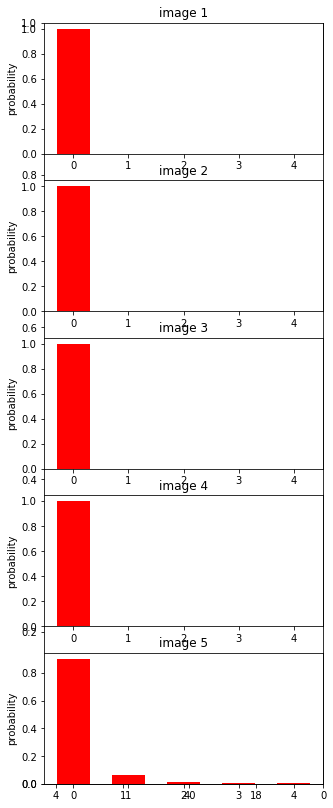

In [25]:
fig, ax = plt.subplots(figsize=(5,14))
for _num in range(5): 
    fig.add_subplot(5,1,_num+1)
    x_axis = np.arange(5)
    plt.bar(x_axis, _softmax_v[_num,:], 0.6, color='r')
    plt.ylabel('probability')
    plt.title('image %d' % (_num+1))
    ax.set_xticks(x_axis + .35 / 2)
    # get the label
    _s = list()
    for i in range(5):
        _t = '%d' % _softmax_i[_num,i]
        _s.append(_t)
    _ = ax.set_xticklabels(_s)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [26]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents 
#              the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, 
#             by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, 
#             just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable 
    #                  from inside a function
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    print('Layer output shape: {}'.format(activation.shape))
    featuremaps = activation.shape[3]
    rows        = featuremaps // 8
    print('Feature maps: {}'.format(featuremaps))
    plt.figure(plt_num, figsize=(16,2*rows))
    for featuremap in range(featuremaps):
        plt.subplot(rows,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            (plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", 
                        vmin =activation_min, vmax=activation_max, cmap="gray"))
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Layer output shape: (1, 14, 14, 64)
Feature maps: 64


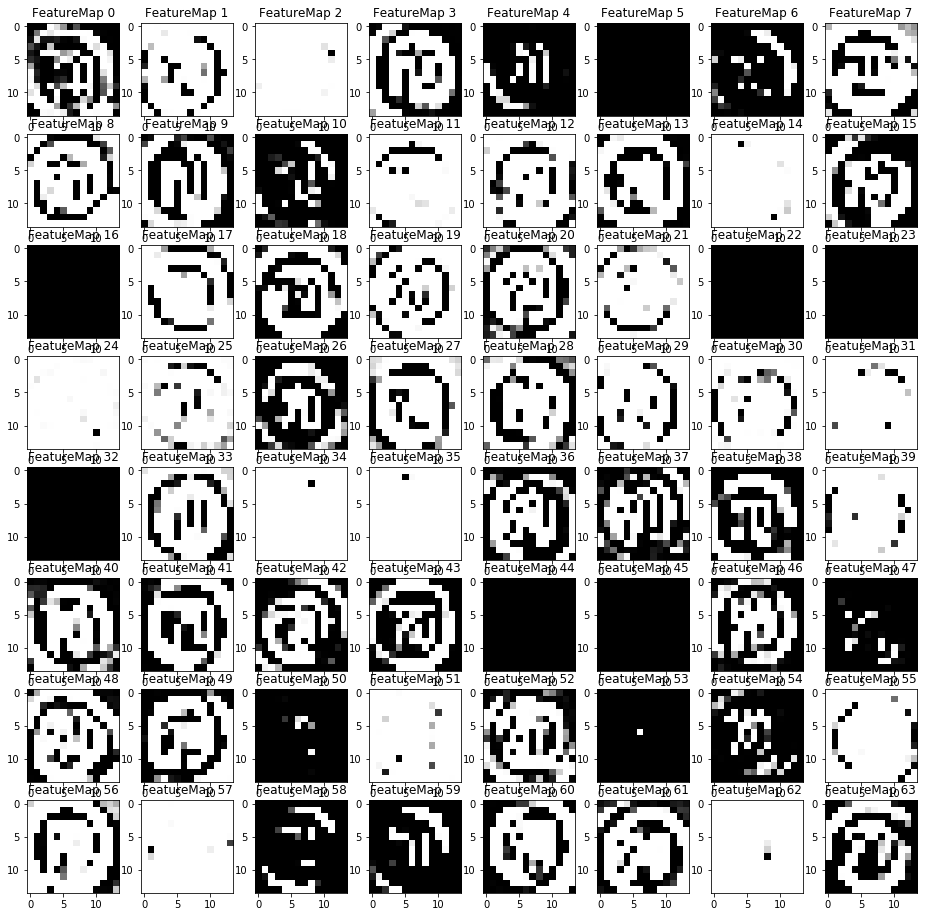

In [27]:
my_image  =  np.expand_dims(x_explore[4], 0)
my_tensor = 'conv1_out:0'

my_image  = my_image.astype(np.float32) 

with tf.Session() as sess:
    my_tensor = tf.get_default_graph().get_tensor_by_name(my_tensor)
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(my_image, my_tensor)